<a href="https://colab.research.google.com/github/HenriARM/ML/blob/master/dice-cnn/dice-cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Implementing CNN Model using TensorFlow for dice image sum recognition.

In [0]:
# Load the Drive helper and mount
from google.colab import  drive

# This will prompt for authorization.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# After executing the cell above, files will be present in "/content/drive/My Drive. Test that dice data is there"
!ls "/content/drive/My Drive/Colab Notebooks/dice-cnn/data"

dice_00.dat  dice_02.dat  dice_04.dat  dice_06.dat  dice_08.dat
dice_01.dat  dice_03.dat  dice_05.dat  dice_07.dat  dice_09.dat


In [0]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['image.cmap'] = 'gray'
def show_pictures(pictures, values):
  for n in range(40):
    plt.subplot(4,10,n+1) # subplot(nrows, ncols, index), index starts at 1 in the upper left corner and increases to the right
    plt.title(values[n])
    plt.imshow(pictures[n].reshape(20,20))
    plt.axis('off')

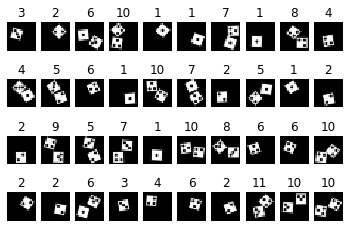

In [0]:
import numpy as np
def read_vectors(filename):
  return np.fromfile(filename, dtype=np.uint8).reshape(-1,401)

dice_00 = read_vectors("/content/drive/My Drive/Colab Notebooks/dice-cnn/data/dice_00.dat")
pictures_00 = dice_00[:,1:]
values_00 = dice_00[:,0]
show_pictures(pictures_00, values_00)

In [0]:
dices = read_vectors("/content/drive/My Drive/Colab Notebooks/dice-cnn/data/dice_00.dat")
for i in range(1,10):
    dices = np.vstack((dices, read_vectors(f"/content/drive/My Drive/Colab Notebooks/dice-cnn/data/dice_0{i}.dat")))

pictures = dices[0:,1:] / 255.0
values = dices[:,0]

In [0]:
%tensorflow_version 2.x
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras import utils
from tensorflow.keras.layers import *
from sklearn.model_selection import train_test_split

In [0]:
x_train, x_test, y_train, y_test = train_test_split(pictures, values, test_size=0.2)

In [0]:
x_train = x_train.reshape(-1,20,20,1)
x_test = x_test.reshape(-1,20,20,1)

# convert vector to matrix of classes, where vectors value is index of class, in our case, summ of 1..2 dices is [1,12]
y_train = utils.to_categorical(y_train, 13)
y_test = utils.to_categorical(y_test, 13)

In [0]:
# I was trying to implement mini-version of VGG-16, but it's very heavy and long to train https://towardsdatascience.com/illustrated-10-cnn-architectures-95d78ace614d#c5a6, 
model = Sequential([
    Conv2D(64, (3,3), input_shape=(20,20,1), activation='relu'),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Conv2D(128, (3,3), activation='relu'),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dense(128, activation='relu'),
    Dense(128, activation='relu'),
    Flatten(),
    Dense(13, activation='softmax')
])
model.summary()


Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 18, 18, 64)        640       
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 6, 6, 128)         73856     
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 4, 4, 128)         147584    
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 2, 2, 128)         0         
_________________________________________________________________
dense_13 (Dense)             (None, 2, 2, 128)        

In [0]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(x_train, y_train, epochs=1, batch_size=500, verbose=1)

Train on 800000 samples
800000/800000 [==============================] - 2189s 3ms/sample - loss: 0.7397 - accuracy: 0.7028


In [0]:
# 20 minutes ~ 1 epoch, but I have saved first epoch in Google Drive and retrieved, to continue trainins

import tensorflow as tf
from keras.models import model_from_json

with open('dice_model.json') as f:
    model_load = f.read()
model = tf.keras.models.model_from_json(model_load)
model.load_weights('dice_model_weights.h5')

In [0]:
# During 3-rd epoch, accuracy improvement stopped, and even was going down. what is the reason?
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(x_train, y_train, epochs=2, batch_size=500, verbose=1)

Train on 800000 samples
Epoch 1/2
800000/800000 [==============================] - 2314s 3ms/sample - loss: 0.2797 - accuracy: 0.9360
Epoch 2/2
112500/800000 [===>..........................] - ETA: 33:44 - loss: 0.0681 - accuracy: 0.9795

KeyboardInterrupt: ignored

In [0]:
model.evaluate(x_test,  y_test, verbose=2)

200000/200000 - 136s - loss: 0.0668 - accuracy: 0.9796


[0.06676314936585724, 0.97955]